# Intro

In [1]:
import json
import pandas as pd
import numpy as np
import sys
from sklearn.model_selection import train_test_split

In [2]:
from eli5.sklearn import PermutationImportance

In [3]:
import shap
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import xgboost
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier

In [4]:
import lime 
from lime import lime_tabular

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import PrecisionRecallDisplay

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from numpy import loadtxt
from sklearn.inspection import permutation_importance

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras import regularizers
from keras.layers import Dense, Dropout

# Output

In [8]:
with open('Reddit.txt') as f:
    data = f.read()

In [9]:
data = data.split('data:')
data = data[1:]
number_of_traces = len(data)
number_of_traces

5899

In [10]:
traces = []
for j in np.arange(number_of_traces):
    traces.append(eval(data[j]))

In [11]:
ll=[]
for j in np.arange(number_of_traces):
    ll.append(len(traces[j]['spans']))

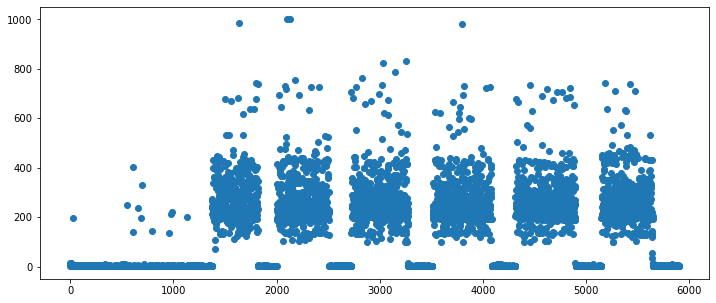

In [12]:
plt.figure(figsize = (12,5))
plt.scatter(np.arange(number_of_traces), ll)
#plt.title('The number of spans in different traces')

In [13]:
traces[10]

{'traceId': 'ab84a01c-04ef-48f4-8f14-ef0eddf5ade7',
 'spans': [{'name': 'Zipkin.ad-selector-canary.get-user-info-local',
   'host': 'zipkin',
   'startMs': 1596127195099,
   'durationMs': 2,
   'spanId': '653b9c49-5d50-4859-a255-a2fbbe1bd8a4',
   'traceId': 'ab84a01c-04ef-48f4-8f14-ef0eddf5ade7',
   'annotations': [{'parent': '9e991f5e-98f9-4bff-9e08-0d780859ebb6'},
    {'followsFrom': '9e991f5e-98f9-4bff-9e08-0d780859ebb6'},
    {'service': 'ad-selector-canary'},
    {'application': 'Zipkin'},
    {'cluster': 'none'},
    {'component': 'baseplate'},
    {'shard': 'none'},
    {'spanId': '653b9c49-5d50-4859-a255-a2fbbe1bd8a4'},
    {'traceId': 'ab84a01c-04ef-48f4-8f14-ef0eddf5ade7'},
    {'parent': '9e991f5e-98f9-4bff-9e08-0d780859ebb6'},
    {'error': 'true'},
    {'ipv4': '10.96.136.183'},
    {'_operationName': 'get-user-info-local'},
    {'_matched': 'true'}]},
  {'name': 'Zipkin.ad-selector-canary.getadsstruct',
   'host': 'zipkin',
   'startMs': 1596127195099,
   'durationMs': 3,

In [14]:
def reduce(function, iterable, initializer=None):
    it = iter(iterable)
    if initializer is None:
        try:
            initializer = next(it)
        except StopIteration:
            raise TypeError('reduce() of empty sequence with no initial value')
    accum_value = initializer
    for x in it:
        accum_value = function(accum_value, x)
    return accum_value

In [15]:
output = np.zeros(number_of_traces)
for j in np.arange(number_of_traces):
    trace = traces[j]
    spans = trace['spans']
    number_of_spans = len(spans)
    for i in np.arange(number_of_spans):
        dicts = spans[i]['annotations']
        new_dicts = reduce(lambda d, src: d.update(src) or d, dicts, {})
        if 'error' in new_dicts.keys():
            output[j] = 1 
            break

In [16]:
np.unique(output, return_counts = True)

(array([0., 1.]), array([3145, 2754], dtype=int64))

# Datasets

In [17]:
all_spans_name = []
numbers = []
for j in np.arange(number_of_traces):
    trace = traces[j]
    spans = trace['spans']
    number_of_spans = len(spans)
    numbers.append(number_of_spans)
    for i in np.arange(number_of_spans):
        name = spans[i]['name']
        all_spans_name.append(name) 
unique_spans_names = np.unique(all_spans_name)
len(unique_spans_names)

451

In [18]:
np.set_printoptions(threshold=5)
unique_spans_names

array(['Zipkin.activity.count_activity_multi',
       'Zipkin.activity.record_activity',
       'Zipkin.activity.redis.pipeline_cache', ...,
       'Zipkin.user-db-api-prod.getuserinfostruct',
       'Zipkin.user-db-api-prod.user-db-with-retry.getuserinfostruct',
       'Zipkin.user-db-api-prod.user-db.getuserinfostruct'], dtype='<U87')

In [19]:
df_span_names = pd.DataFrame(index = np.arange(number_of_traces), columns = unique_spans_names)

In [20]:
for j in np.arange(number_of_traces):
    trace = traces[j]
    spans = trace['spans']
    number_of_spans = len(spans)
    for i in np.arange(number_of_spans):
        name = spans[i]['name']
        df_span_names.loc[j,name] = 1

In [21]:
df_span_names.shape

(5899, 451)

In [22]:
total_number_of_values = number_of_traces * len(unique_spans_names)
np.sum(np.sum(df_span_names.isnull()))/total_number_of_values*100

90.41676799668026

In [23]:
df_span_names_repetitions = pd.DataFrame(index = np.arange(number_of_traces), columns = unique_spans_names)

In [24]:
for j in np.arange(number_of_traces):
    trace = traces[j]
    spans = trace['spans']
    number_of_spans = len(spans)
    name = []
    for i in np.arange(number_of_spans):
        name.append(spans[i]['name']) 
    span_name_counts = np.unique(name,return_counts = True) 
    for k in np.arange(len(span_name_counts[0])):
        df_span_names_repetitions.loc[j,span_name_counts[0][k]] = span_name_counts[1][k]

In [25]:
df_span_names_repetitions.shape

(5899, 451)

In [26]:
column_names = []
for j in np.arange(number_of_traces):
    length_of_trace = len(traces[j]['spans'])
    for i in np.arange(length_of_trace):
        name1 = traces[j]['spans'][i]['name'] + '_host'
        column_names.append(name1)
        name2 = traces[j]['spans'][i]['name'] + '_durationMs'
        column_names.append(name2)
        dicts = traces[j]['spans'][i]['annotations']
        new_dicts = reduce(lambda d, src: d.update(src) or d, dicts, {})
        del(new_dicts['spanId'])
        del(new_dicts['traceId'])
        if 'error' in new_dicts.keys(): 
            del(new_dicts['error'])
        if 'parent' in new_dicts.keys(): 
            del(new_dicts['parent'])
        if 'followsFrom' in new_dicts.keys(): 
            del(new_dicts['followsFrom'])
        annotation_names = list(new_dicts.keys())
        annotation_names_length = len(annotation_names)
        for s in np.arange(annotation_names_length):
            name = traces[j]['spans'][i]['name'] + '_annotations' + '_' + annotation_names[s]
            column_names.append(name)
unique_column_names = np.unique(column_names)

In [27]:
len(unique_column_names)

4916

In [28]:
unique_column_names

array(['Zipkin.activity.count_activity_multi_annotations__matched',
       'Zipkin.activity.count_activity_multi_annotations__operationName',
       'Zipkin.activity.count_activity_multi_annotations_application',
       ...,
       'Zipkin.user-db-api-prod.user-db.getuserinfostruct_annotations_span.kind',
       'Zipkin.user-db-api-prod.user-db.getuserinfostruct_durationMs',
       'Zipkin.user-db-api-prod.user-db.getuserinfostruct_host'],
      dtype='<U114')

In [29]:
df_dimensions = pd.DataFrame(index = np.arange(number_of_traces), columns = unique_column_names)

In [30]:
name_list = []
for j in np.arange(number_of_traces):
    length_of_trace = len(traces[j]['spans'])
    for i in np.arange(length_of_trace):
        name1 = traces[j]['spans'][i]['name'] + '_host'
        df_dimensions.loc[j,name1] = traces[j]['spans'][i]['host']
        name2 = traces[j]['spans'][i]['name'] + '_durationMs'
        df_dimensions.loc[j,name2] = traces[j]['spans'][i]['durationMs']
        dicts = traces[j]['spans'][i]['annotations']
        new_dicts = reduce(lambda d, src: d.update(src) or d, dicts, {})
        del(new_dicts['spanId'])
        del(new_dicts['traceId'])
        if 'error' in new_dicts.keys(): 
            del(new_dicts['error'])
        if 'parent' in new_dicts.keys(): 
            del(new_dicts['parent'])
        if 'followsFrom' in new_dicts.keys(): 
            del(new_dicts['followsFrom'])
        annotation_names = list(new_dicts.keys())
        for s in list(new_dicts.keys()):
            name = traces[j]['spans'][i]['name'] + '_annotations' + '_' + s 
            df_dimensions.loc[j,name] = new_dicts[s]

In [31]:
df_dimensions.shape

(5899, 4916)

In [32]:
total_number_of_values = number_of_traces * (len(unique_spans_names) + len(unique_column_names))
np.sum(np.sum(df_dimensions.isnull()))/total_number_of_values*100

82.81232622949645

# Data Short

In [41]:
dd = df_span_names.loc[output == 1,:]
isnull_index = np.sum(dd.isnull()) == dd.shape[0]
df_span_names_short = df_span_names.drop(dd.columns[isnull_index], axis = 1)
df_span_names_repetitions_short = df_span_names_repetitions.drop(dd.columns[isnull_index], axis = 1)

In [42]:
df_span_names_short.shape

(5899, 199)

In [43]:
df_span_names_repetitions_short.shape

(5899, 199)

In [44]:
df_span_names_short['output'] = output
df_span_names_short.to_csv("outputs/df_span_names_short.csv", index = False)

In [45]:
df_span_names_repetitions_short['output'] = output
df_span_names_repetitions_short.to_csv("outputs/df_span_names_repetitions_short.csv", 
                                       index = False)

In [46]:
dd = df_dimensions.loc[output == 1,:]
isnull_index = np.sum(dd.isnull()) == dd.shape[0]
df_dimensions_short = df_dimensions.drop(dd.columns[isnull_index], axis = 1)

In [47]:
df_dimensions_short.shape

(5899, 2168)

In [48]:
df_dimensions_short['output'] = output
df_dimensions_short.to_csv("outputs/df_dimensions_short.csv", index = False)

# Data Download and Transformations

In [229]:
df_span_names_short = pd.read_csv("outputs/df_span_names_short.csv")
y = df_span_names_short['output'].astype('category')
X_df_span_names_short = df_span_names_short.drop(['output'], axis = 1).astype('category')

In [230]:
np.sum(X_df_span_names_short.dtypes == 'category')

199

In [231]:
df_span_names_repetitions_short = pd.read_csv("outputs/df_span_names_repetitions_short.csv")
X_df_span_names_repetitions_short = df_span_names_repetitions_short.drop(['output'], axis = 1).astype('category')

In [232]:
np.sum(X_df_span_names_repetitions_short.dtypes == 'category')

199

In [233]:
df_dimensions_short = pd.read_csv("outputs/df_dimensions_short.csv",
                                 low_memory = False)
X_df_dimensions_short = df_dimensions_short.drop(['output'], axis = 1)

In [234]:
import re
index_num = []
index_cat = []
index_card = []
for j in X_df_dimensions_short.columns:
    result = re.search("durationMs", j)
    cardinality = X_df_dimensions_short[j].nunique()
    if (result != None):
        index_num.append(j)
    elif (cardinality > 20):
        index_card.append(j)
    else:
        index_cat.append(j)

In [235]:
mm = OrdinalEncoder()
m1 = pd.DataFrame(mm.fit_transform(X_df_dimensions_short[index_cat]), columns = index_cat).astype('category')
m2 = pd.DataFrame(mm.fit_transform(X_df_dimensions_short[index_card]), columns = index_card).astype('float64')
m3 = X_df_dimensions_short[index_num].astype('float64')
df_dimensions_trans = pd.concat([m1,m2,m3], axis = 1)

In [236]:
df_dimensions_trans_w_durations = pd.concat([m1,m2], axis = 1)

In [237]:
X_df_span_names_repetitions_short.shape

(5899, 199)

In [238]:
ind = X_df_span_names_repetitions_short.nunique() < 150
X_df_span_names_repetitions_short = X_df_span_names_repetitions_short.loc[:,ind]

In [239]:
X_df_span_names_repetitions_short.shape

(5899, 197)

In [240]:
df_full_short = pd.concat([X_df_span_names_short, df_dimensions_trans], axis = 1)
df_full_repetitions_short = pd.concat([X_df_span_names_repetitions_short, df_dimensions_trans], axis = 1)
df_full_short_w_durations = pd.concat([X_df_span_names_short, df_dimensions_trans_w_durations], axis = 1)
df_full_short_repetitions_w_durations = pd.concat([X_df_span_names_repetitions_short, df_dimensions_trans_w_durations], axis = 1)

In [185]:
# for Weka
#df_full_short['output'] = output
#df_full_short.to_csv("outputs/df_full_short.csv", index = False)
#df_full_short.drop(['output'], axis = 1, inplace = True)

#df_full_repetitions_short['output'] = output
#df_full_repetitions_short.to_csv("outputs/df_full_repetitions_short.csv", index = False)
#df_full_repetitions_short.drop(['output'], axis = 1, inplace = True)

#df_full_short_w_durations['output'] = output
#df_full_short_w_durations.to_csv("outputs/df_full_short_w_durations.csv", index = False)
#df_full_short_w_durations.drop(['output'], axis = 1, inplace = True)

#df_full_short_repetitions_w_durations['output'] = output
#df_full_short_repetitions_w_durations.to_csv("outputs/df_full_short_repetitions_w_durations.csv", index = False)
#df_full_short_repetitions_w_durations.drop(['output'], axis = 1, inplace = True)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


# XGBoost - Span Names

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_df_span_names_short, y, random_state = 0)

In [64]:
model_xgb = XGBClassifier(tree_method = "gpu_hist", enable_categorical = True)
n_estimators_grid = np.arange(5, 200, 5)
learning_rate_grid = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
model_optimal_xgb = GridSearchCV(model_xgb, 
        param_grid = {'n_estimators': n_estimators_grid,
                     'learning_rate': learning_rate_grid},
                     n_jobs = -1, verbose = 5, return_train_score = True)
model_optimal_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 234 candidates, totalling 1170 fits


DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_to_o...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     n

In [65]:
model_optimal_xgb.best_params_

{'learning_rate': 1, 'n_estimators': 60}

In [66]:
pred_xgb = model_optimal_xgb.predict(X_train)
print(classification_report(y_train, pred_xgb))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2364
         1.0       1.00      0.99      1.00      2060

    accuracy                           1.00      4424
   macro avg       1.00      1.00      1.00      4424
weighted avg       1.00      1.00      1.00      4424



In [67]:
pred_xgb = model_optimal_xgb.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       781
         1.0       1.00      0.99      0.99       694

    accuracy                           1.00      1475
   macro avg       1.00      1.00      1.00      1475
weighted avg       1.00      1.00      1.00      1475



DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


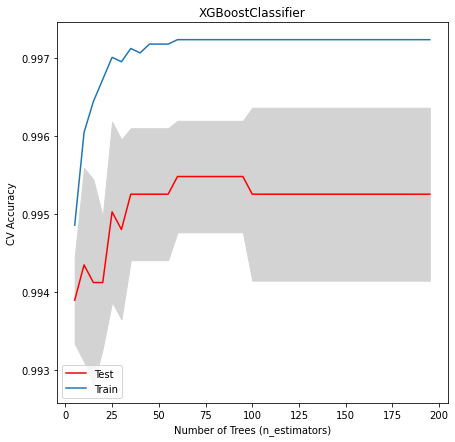

In [68]:
test = model_optimal_xgb.cv_results_['mean_test_score'].reshape(len(learning_rate_grid), len(n_estimators_grid))[5]
test_std = model_optimal_xgb.cv_results_['std_test_score'].reshape(len(learning_rate_grid), len(n_estimators_grid))[5]
train =  model_optimal_xgb.cv_results_['mean_train_score'].reshape(len(learning_rate_grid), len(n_estimators_grid))[5]
train_std =  model_optimal_xgb.cv_results_['std_train_score'].reshape(len(learning_rate_grid), len(n_estimators_grid))[5]
plt.figure(figsize = (7,7))
plt.plot(n_estimators_grid, test, label = "Test", c = 'red')
plt.fill_between(x = n_estimators_grid, y1 = test- test_std, y2 = test + test_std, color = "lightgrey")
plt.plot(n_estimators_grid, train, label = "Train")
plt.legend()
plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('CV Accuracy')
plt.title('XGBoostClassifier')
plt.show()


In [70]:
model_final_xgb = XGBClassifier(tree_method = "gpu_hist", enable_categorical = True, n_estimators = 60, learning_rate = 1)
model_final_xgb.fit(X_df_span_names_short, y)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='', learning_rate=1,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=60, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [71]:
sorted(list(zip(X_df_span_names_short.columns, model_final_xgb.feature_importances_)), 
       key = lambda x: abs(x[1]), reverse = True)

[('Zipkin.ad-selector-canary.compare-edge-context', 0.56263876),
 ('Zipkin.ad-selector-canary.post-process-ads', 0.35674182),
 ('Zipkin.ad-selector-canary.ad-selector-shard', 0.040955536),
 ('Zipkin.ad-selector-canary.target-flights', 0.0030775252),
 ('Zipkin.thing.srmember_db_secondary.execute', 0.0020224617),
 ('Zipkin.ad-selector-canary.inference.selectandpredict', 0.0014367237),
 ('Zipkin.session.authentication.authenticate_oauth2_bearer_token',
  0.0013969687),
 ('Zipkin.ad-selector-canary.user-db.getuserinfostruct', 0.00135847),
 ('Zipkin.ad-selector-canary.user-db-with-retry.getuserinfostruct',
  0.0013419959),
 ('Zipkin.graphql.thing_service.get_favorite_subreddits', 0.0012639668),
 ('Zipkin.preference_service.cassandra.execute', 0.0011337661),
 ('Zipkin.ad-selector-canary.getadsstruct', 0.0010263608),
 ('Zipkin.r2.api.post_sidebar_ads', 0.0010138076),
 ('Zipkin.thing.get_identity', 0.0009775476),
 ('Zipkin.graphql.award_service.get_posts_top_awarded_type', 0.00094653876),
 ('Z

In [72]:
imp = sorted(list(zip(X_df_span_names_short.columns, model_final_xgb.feature_importances_)), 
       key = lambda x: abs(x[1]), reverse = True)
names = []
scores = []
for j in np.arange(5):
    names.append(imp[j][0])
    scores.append(imp[j][1])

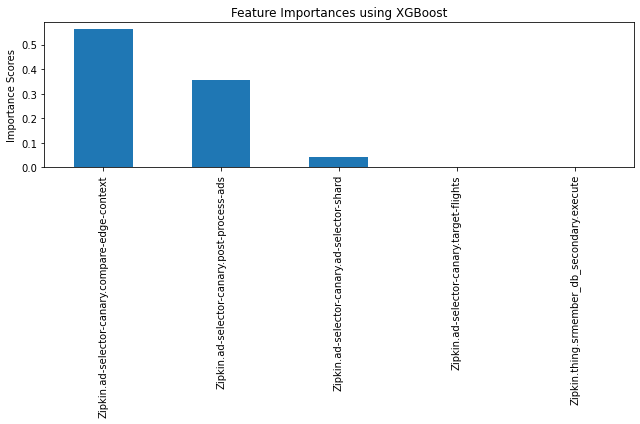

In [73]:
importances = scores
forest_importances = pd.Series(scores, index = names)

fig, ax = plt.subplots(figsize = (9,6))
forest_importances.plot.bar(ax = ax)
ax.set_title("Feature Importances using XGBoost")
ax.set_ylabel("Importance Scores")
fig.tight_layout()

In [75]:
result = permutation_importance(model_final_xgb, X_df_span_names_short, y, n_repeats = 5, random_state = 42, n_jobs = -1)

forest_importances = pd.Series(result.importances_mean, index = X_df_span_names_short.columns)

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [77]:
imp = sorted(list(zip(X_df_span_names_short.columns,result['importances_mean'])), key = lambda x: abs(x[1]), reverse = True)
names = []
scores = []
for j in np.arange(5):
    names.append(imp[j][0])
    scores.append(imp[j][1])

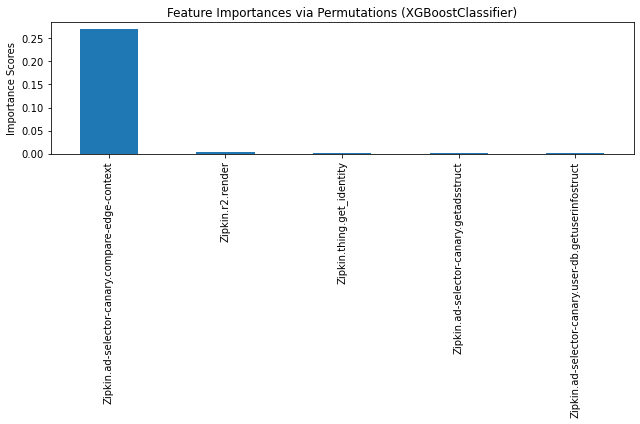

In [78]:
importances = scores
forest_importances = pd.Series(scores, index = names)

fig, ax = plt.subplots(figsize=(9,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances via Permutations (XGBoostClassifier)")
ax.set_ylabel("Importance Scores")
fig.tight_layout()

In [79]:
model = HistGradientBoostingClassifier(categorical_features = [True]*X_df_span_names_short.shape[1])
learning_rate_grid = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
model_optimal = GridSearchCV(model, 
        param_grid = {'learning_rate': learning_rate_grid},
                     n_jobs = -1, verbose = 5, return_train_score = True)
model_optimal.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=HistGradientBoostingClassifier(categorical_features=[True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                

In [80]:
model_optimal.best_params_

{'learning_rate': 0.01}

In [81]:
pred_xgb = model_optimal.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       781
         1.0       1.00      0.99      1.00       694

    accuracy                           1.00      1475
   macro avg       1.00      1.00      1.00      1475
weighted avg       1.00      1.00      1.00      1475



In [83]:
model_final = HistGradientBoostingClassifier(learning_rate = 0.01, categorical_features = [True]*X_df_span_names_short.shape[1])
model_final.fit(X_df_span_names_short, y)

HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, ...],
                               learning_rate=0.01)

In [84]:
result = permutation_importance( model_final, X_df_span_names_short, y, n_repeats = 5, 
    random_state = 42, n_jobs = -1)

forest_importances = pd.Series(result.importances_mean, index = X_df_span_names_short.columns)

In [85]:
imp = sorted(list(zip(X_df_span_names_short.columns,result['importances_mean'])), 
             key = lambda x: abs(x[1]), reverse = True)
names = []
scores = []
for j in np.arange(5):
    names.append(imp[j][0])
    scores.append(imp[j][1])

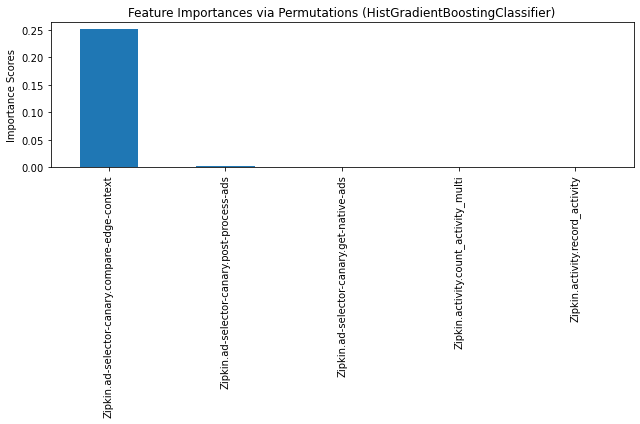

In [86]:
importances = scores
forest_importances = pd.Series(scores, index = names)

fig, ax = plt.subplots(figsize=(9,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances via Permutations (HistGradientBoostingClassifier)")
ax.set_ylabel("Importance Scores")
fig.tight_layout()

In [87]:
dd = X_df_span_names_short.loc[y == 1,:]
y_short = y[y==1]

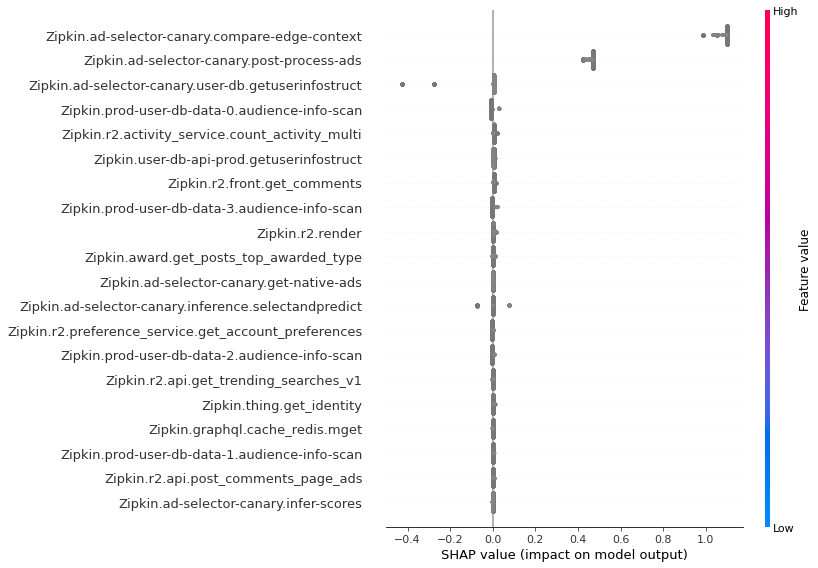

In [88]:
sv = shap.TreeExplainer(model_final,  enable_categorical = True)
shap_values = sv.shap_values(dd.values, y_short.values)
shap.summary_plot(shap_values, dd.values, feature_names = dd.columns)

# XGBoost - Span Names  with Repetitions

In [154]:
X_train, X_test, y_train, y_test = train_test_split(X_df_span_names_repetitions_short, y)

In [159]:
model = HistGradientBoostingClassifier( )
learning_rate_grid = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
model_optimal = GridSearchCV(model, 
        param_grid = {'learning_rate': learning_rate_grid},
                     n_jobs = -1, verbose = 5, return_train_score = True)
model_optimal.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=HistGradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.5, 1]},
             return_train_score=True, verbose=5)

In [160]:
model_optimal.best_params_

{'learning_rate': 1}

In [163]:
pred_xgb = model_optimal.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       789
         1.0       1.00      1.00      1.00       686

    accuracy                           1.00      1475
   macro avg       1.00      1.00      1.00      1475
weighted avg       1.00      1.00      1.00      1475



In [166]:
model_final = HistGradientBoostingClassifier(learning_rate = 1)
model_final.fit(X_df_span_names_repetitions_short, y)

HistGradientBoostingClassifier(learning_rate=1)

In [168]:
result = permutation_importance(
   model_final, X_df_span_names_repetitions_short, y, n_repeats = 5, 
    random_state = 42, n_jobs = -1)

forest_importances = pd.Series(result.importances_mean, index = X_df_span_names_repetitions_short.columns)

In [169]:
imp = sorted(list(zip(X_df_span_names_repetitions_short.columns,result['importances_mean'])), 
             key = lambda x: abs(x[1]), reverse = True)
names = []
scores = []
for j in np.arange(5):
    names.append(imp[j][0])
    scores.append(imp[j][1])

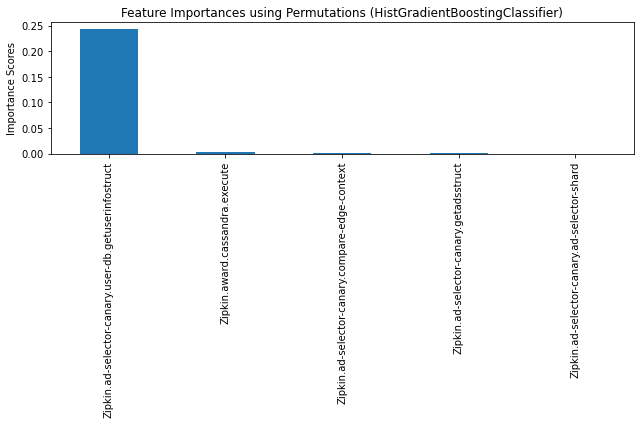

In [170]:
importances = scores
forest_importances = pd.Series(scores, index = names)

fig, ax = plt.subplots(figsize=(9,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Permutations (HistGradientBoostingClassifier)")
ax.set_ylabel("Importance Scores")
fig.tight_layout()

In [171]:
dd = X_df_span_names_repetitions_short.loc[y == 1,:]
y_short = y[y==1]

In [172]:
sv = shap.TreeExplainer(model_final,  enable_categorical = True)
shap_values = sv.shap_values(dd,y_short)

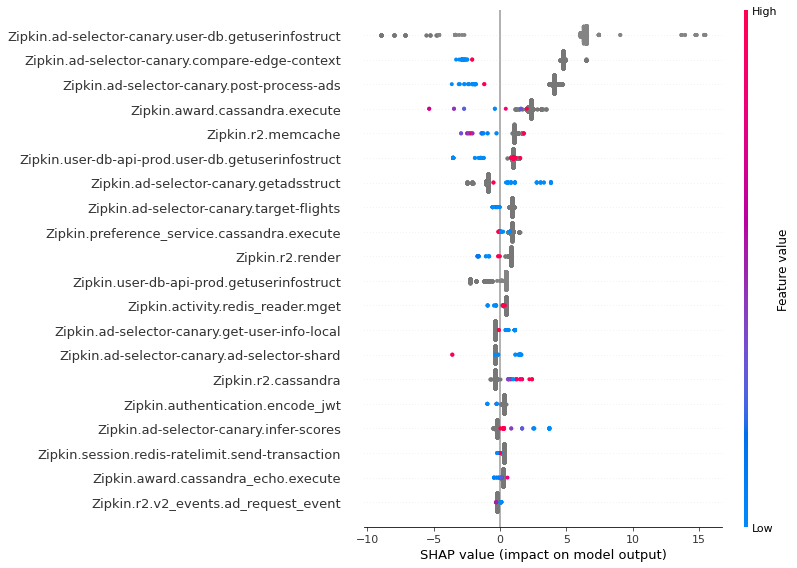

In [174]:
shap.summary_plot(shap_values, dd.values, feature_names = X_df_span_names_repetitions_short.columns)

# Full 

In [186]:
X_train, X_test, y_train, y_test = train_test_split(df_full_short, y)

In [187]:
model = HistGradientBoostingClassifier(categorical_features = [True]*199 + [True]*len(index_cat) + [False]*len(index_card) + [False]*len(index_num))
learning_rate_grid = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
model_optimal = GridSearchCV(model, 
        param_grid = {'learning_rate': learning_rate_grid},
                     n_jobs = -1, verbose = 5, return_train_score = True)
model_optimal.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=HistGradientBoostingClassifier(categorical_features=[True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                

In [188]:
model_optimal.best_params_

{'learning_rate': 0.01}

In [189]:
pred_xgb = model_optimal.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       772
         1.0       1.00      0.99      0.99       703

    accuracy                           0.99      1475
   macro avg       0.99      0.99      0.99      1475
weighted avg       0.99      0.99      0.99      1475



In [192]:
model_final = HistGradientBoostingClassifier(learning_rate = 0.01, 
            categorical_features = [True]*199 + [True]*len(index_cat) + [False]*len(index_card) + [False]*len(index_num))
model_final.fit(df_full_short, y)

HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, ...],
                               learning_rate=0.01)

In [193]:
result = permutation_importance(
   model_final, df_full_short, y, n_repeats = 5, 
    random_state = 42, n_jobs = -1)

forest_importances = pd.Series(result.importances_mean, index = df_full_short.columns)

In [194]:
imp = sorted(list(zip(df_full_short.columns, result['importances_mean'])), key = lambda x: abs(x[1]), reverse = True)
names = []
scores = []
for j in np.arange(5):
    names.append(imp[j][0])
    scores.append(imp[j][1])

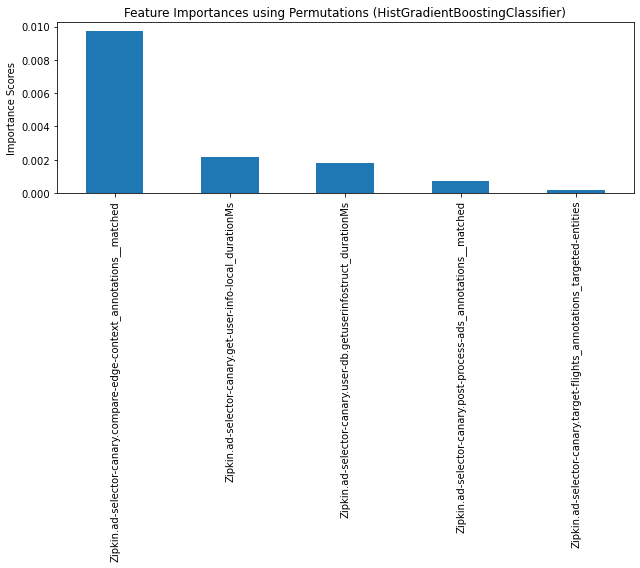

In [195]:
importances = scores
forest_importances = pd.Series(scores, index = names)

fig, ax = plt.subplots(figsize=(9,8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Permutations (HistGradientBoostingClassifier)")
ax.set_ylabel("Importance Scores")
fig.tight_layout()

In [196]:
dd = df_full_short.loc[y == 1,:]
y_short = y[y==1]

In [197]:
sv = shap.TreeExplainer(model_final,  enable_categorical = True)
shap_values = sv.shap_values(dd,y_short)

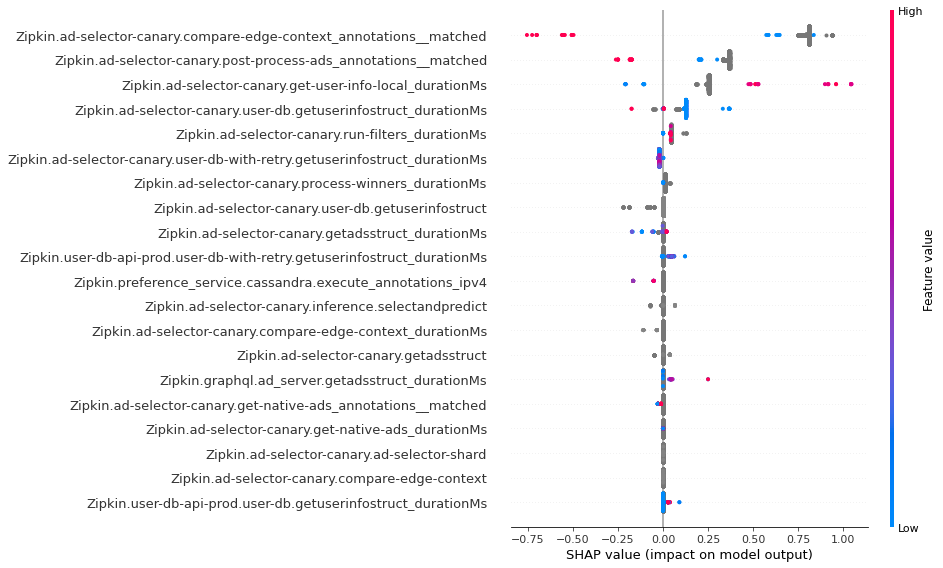

In [198]:
shap.summary_plot(shap_values, dd.values,  feature_names = dd.columns)

In [199]:
X_train, X_test, y_train, y_test = train_test_split(df_full_short_w_durations, y)

In [200]:
model = HistGradientBoostingClassifier(categorical_features = [True]*199 + [True]*len(index_cat) + [False]*len(index_card) )
learning_rate_grid = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
model_optimal = GridSearchCV(model, 
        param_grid = {'learning_rate': learning_rate_grid},
                     n_jobs = -1, verbose = 5, return_train_score = True)
model_optimal.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=HistGradientBoostingClassifier(categorical_features=[True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                

In [201]:
model_optimal.best_params_

{'learning_rate': 0.01}

In [202]:
pred_xgb = model_optimal.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       785
         1.0       1.00      0.99      1.00       690

    accuracy                           1.00      1475
   macro avg       1.00      1.00      1.00      1475
weighted avg       1.00      1.00      1.00      1475



In [205]:
model_final = HistGradientBoostingClassifier(learning_rate = 0.01, 
            categorical_features = [True]*199 + [True]*len(index_cat) + [False]*len(index_card))
model_final.fit(df_full_short_w_durations, y)

HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, ...],
                               learning_rate=0.01)

In [206]:
result = permutation_importance(
   model_final, df_full_short_w_durations, y, n_repeats = 5, 
    random_state = 42, n_jobs = -1)

forest_importances = pd.Series(result.importances_mean, index = df_full_short_w_durations.columns)

In [207]:
imp = sorted(list(zip(df_full_short_w_durations.columns, result['importances_mean'])), 
             key = lambda x: abs(x[1]), reverse = True)
names = []
scores = []
for j in np.arange(5):
    names.append(imp[j][0])
    scores.append(imp[j][1])

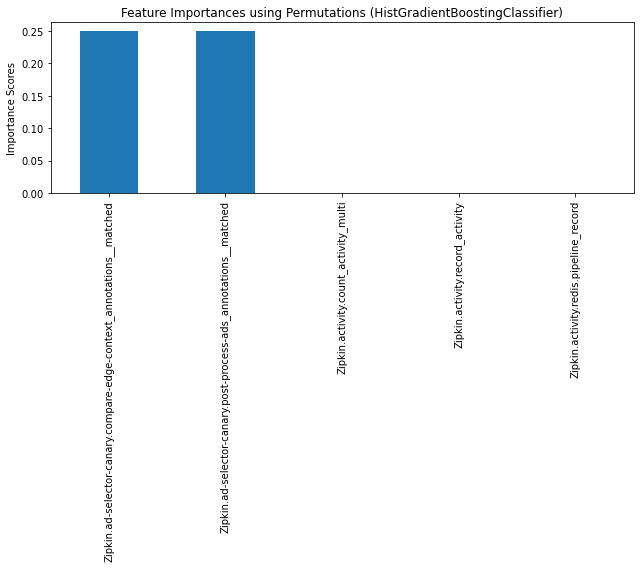

In [208]:
importances = scores
forest_importances = pd.Series(scores, index = names)

fig, ax = plt.subplots(figsize=(9,8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Permutations (HistGradientBoostingClassifier)")
ax.set_ylabel("Importance Scores")
fig.tight_layout()

In [209]:
dd = df_full_short_w_durations.loc[y == 1,:]
y_short = y[y==1]

In [210]:
sv = shap.TreeExplainer(model_final,  enable_categorical = True)
shap_values = sv.shap_values(dd,y_short)

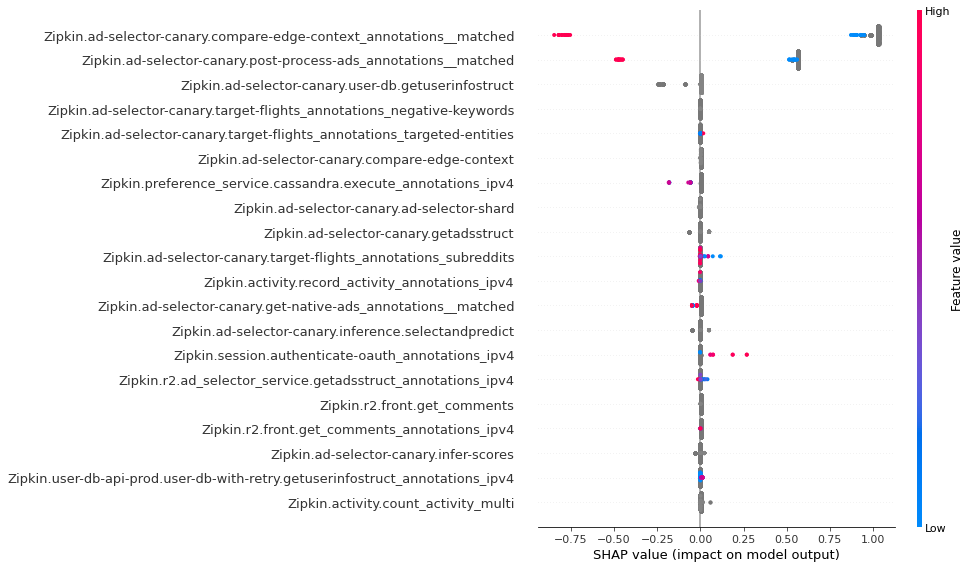

In [211]:
shap.summary_plot(shap_values, dd.values,  feature_names = dd.columns)

# Full  with  Repetitions

In [241]:
df_full_repetitions_short.shape

(5899, 2365)

Text(0, 0.5, 'Number of Spans')

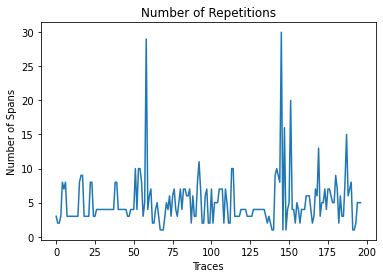

In [260]:
plt.plot(X_df_span_names_repetitions_short.nunique().values)
plt.title("Number of Repetitions")
plt.xlabel("Traces")
plt.ylabel("Number of Spans")

In [242]:
X_train, X_test, y_train, y_test = train_test_split(df_full_repetitions_short, y)

In [243]:
model = HistGradientBoostingClassifier(categorical_features = [True]*197 + [True]*len(index_cat) + [False]*len(index_card) + [False]*len(index_num))
learning_rate_grid = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
model_optimal = GridSearchCV(model, 
        param_grid = {'learning_rate': learning_rate_grid},
                     n_jobs = -1, verbose = 5, return_train_score = True)
model_optimal.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=HistGradientBoostingClassifier(categorical_features=[True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                

In [244]:
model_optimal.best_params_

{'learning_rate': 0.1}

In [245]:
pred_xgb = model_optimal.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       812
         1.0       1.00      1.00      1.00       663

    accuracy                           1.00      1475
   macro avg       1.00      1.00      1.00      1475
weighted avg       1.00      1.00      1.00      1475



In [246]:
model_final = HistGradientBoostingClassifier(learning_rate = 0.1, 
            categorical_features = [True]*197 + [True]*len(index_cat) + [False]*len(index_card) + [False]*len(index_num))
model_final.fit(df_full_repetitions_short, y)

HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, ...])

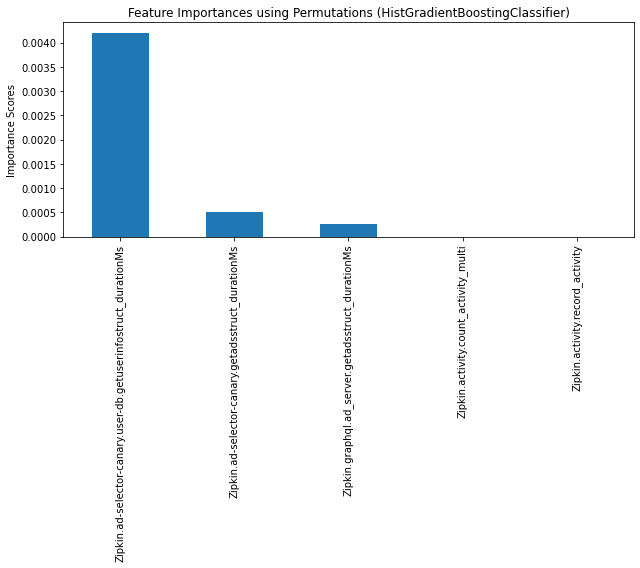

In [247]:
result = permutation_importance(model_final, df_full_repetitions_short, y, n_repeats = 5, 
    random_state = 42, n_jobs = -1)

forest_importances = pd.Series(result.importances_mean, index = df_full_repetitions_short.columns)

imp = sorted(list(zip(df_full_repetitions_short.columns, result['importances_mean'])), 
             key = lambda x: abs(x[1]), reverse = True)
names = []
scores = []
for j in np.arange(5):
    names.append(imp[j][0])
    scores.append(imp[j][1])

importances = scores
forest_importances = pd.Series(scores, index = names)

fig, ax = plt.subplots(figsize=(9,8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Permutations (HistGradientBoostingClassifier)")
ax.set_ylabel("Importance Scores")
fig.tight_layout()

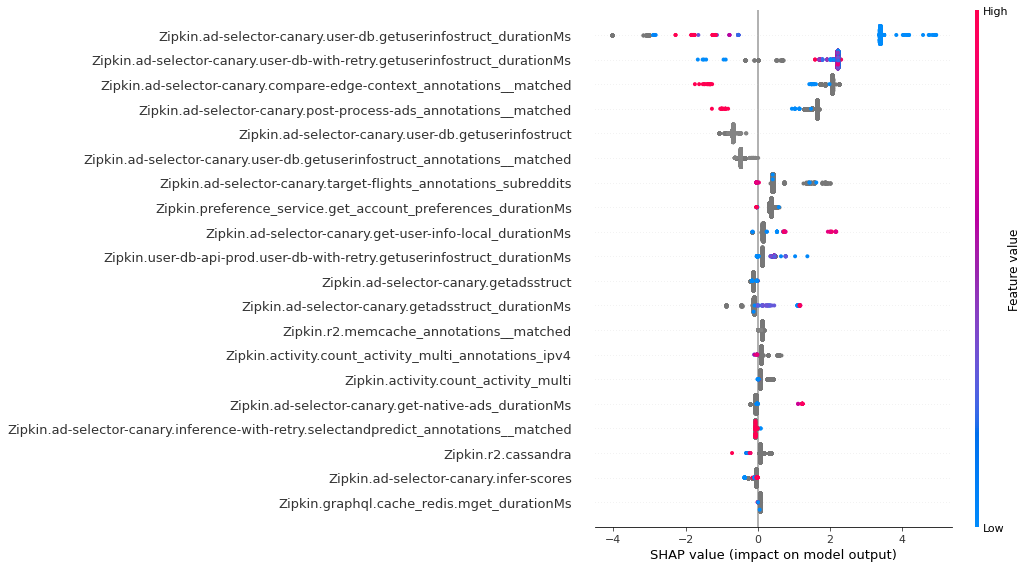

In [249]:
dd = df_full_repetitions_short.loc[y == 1,: ]
y_short = y[y==1]

sv = shap.TreeExplainer(model_final,  enable_categorical = True)
shap_values = sv.shap_values(dd, y_short)

shap.summary_plot(shap_values, dd.values,  feature_names = dd.columns)

In [250]:
X_train, X_test, y_train, y_test = train_test_split(df_full_short_repetitions_w_durations, y)

In [251]:
model = HistGradientBoostingClassifier(categorical_features = [True]*197 + [True]*len(index_cat) + [False]*len(index_card) )
learning_rate_grid = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
model_optimal = GridSearchCV(model, 
        param_grid = {'learning_rate': learning_rate_grid},
                     n_jobs = -1, verbose = 5, return_train_score = True)
model_optimal.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=HistGradientBoostingClassifier(categorical_features=[True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                                                                            True,
                

In [252]:
model_optimal.best_params_

{'learning_rate': 0.1}

In [253]:
pred_xgb = model_optimal.predict(X_test)
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       791
         1.0       1.00      0.99      1.00       684

    accuracy                           1.00      1475
   macro avg       1.00      1.00      1.00      1475
weighted avg       1.00      1.00      1.00      1475



In [254]:
model_final = HistGradientBoostingClassifier(learning_rate = 0.1, 
            categorical_features = [True]*197 + [True]*len(index_cat) + [False]*len(index_card))
model_final.fit(df_full_short_repetitions_w_durations, y)

HistGradientBoostingClassifier(categorical_features=[True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, True, True,
                                                     True, True, ...])

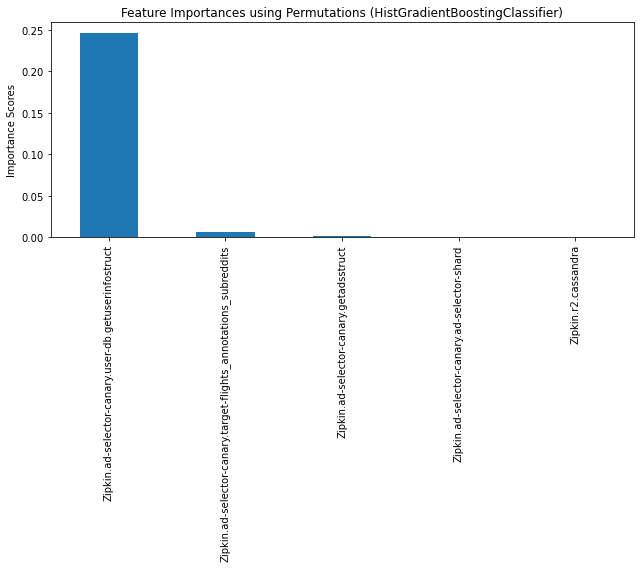

In [255]:
result = permutation_importance(
   model_final, df_full_short_repetitions_w_durations, y, n_repeats = 5, 
    random_state = 42, n_jobs = -1)

forest_importances = pd.Series(result.importances_mean, index = df_full_short_repetitions_w_durations.columns)

imp = sorted(list(zip(df_full_short_repetitions_w_durations.columns, result['importances_mean'])), key = lambda x: abs(x[1]), reverse = True)
names = []
scores = []
for j in np.arange(5):
    names.append(imp[j][0])
    scores.append(imp[j][1])

importances = scores
forest_importances = pd.Series(scores, index = names)

fig, ax = plt.subplots(figsize=(9,8))
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances using Permutations (HistGradientBoostingClassifier)")
ax.set_ylabel("Importance Scores")
fig.tight_layout()

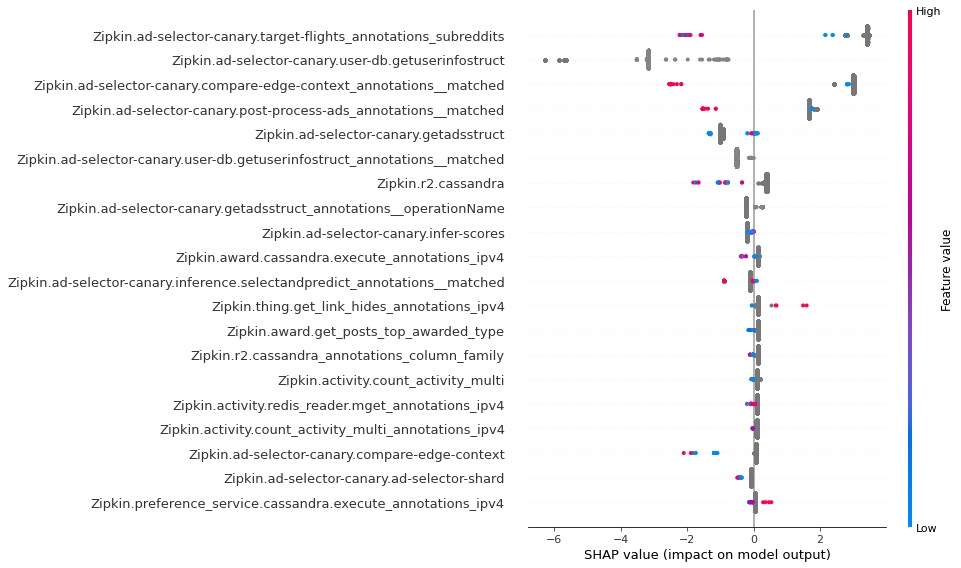

In [256]:
dd = df_full_short_repetitions_w_durations.loc[y == 1,:]
y_short = y[y==1]

sv = shap.TreeExplainer(model_final,  enable_categorical = True)
shap_values = sv.shap_values(dd,y_short)

shap.summary_plot(shap_values, dd.values,  feature_names = dd.columns)

# Visualization

In [10]:
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import pairwise_distances

In [11]:
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold
from sklearn.utils import check_random_state

# Unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
import warnings

In [12]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn.metrics import pairwise_distances

In [13]:
X = df_span_names.drop(['output'], axis = 1)
y = df_span_names['output']
mm = SimpleImputer(strategy = 'constant', fill_value = 0)
X_0 = mm.fit_transform(X)
X_0 = pd.DataFrame(X_0, columns =  X.columns)

In [14]:
from scipy.spatial.distance import cdist

In [15]:
jac_sim = cdist(X_0, X_0, metric = 'jaccard')

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.


Text(0.5, 1.0, 'Traces')

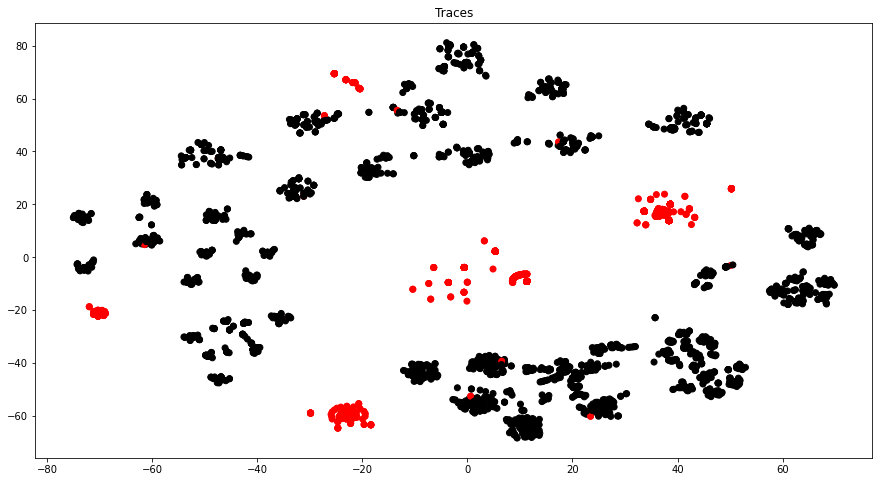

In [91]:
tsne = manifold.TSNE(n_components = 2,  random_state = 0, learning_rate = "auto", metric = 'precomputed')
trans_data = tsne.fit_transform(jac_sim).T

plt.figure(figsize=(15,8))
plt.scatter(trans_data[0], trans_data[1], c = y.ravel(), cmap =  ListedColormap(['black','red']))
plt.title('Traces')

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.


Text(0.5, 0.92, 'Traces')

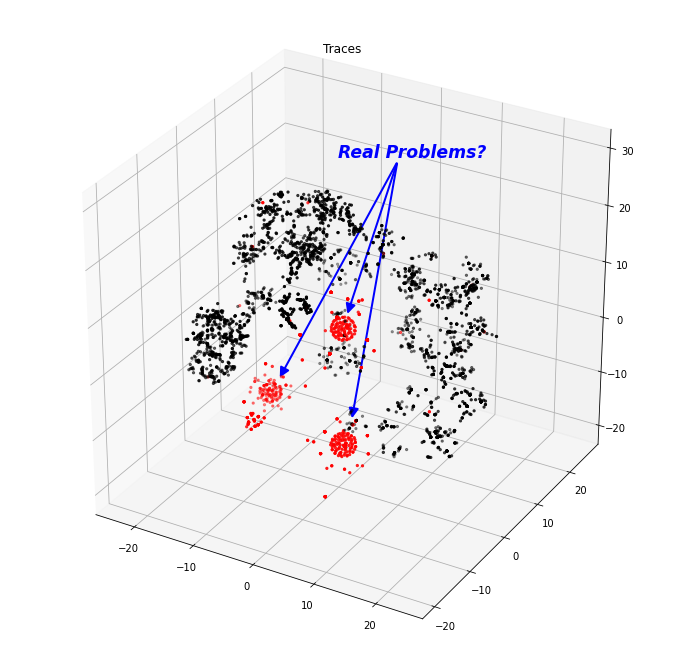

In [18]:
tsne = manifold.TSNE(n_components = 3,  random_state = 0, learning_rate = "auto", metric = 'precomputed')
trans_data = tsne.fit_transform(jac_sim).T

fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection = '3d')

ax.scatter(trans_data[0], trans_data[1], trans_data[2], c = y.ravel(), 
           cmap =  ListedColormap(['black','red']), s = 5)
ax.text3D(0, 0, 35, "Real Problems?", color = 'blue', weight = 'bold', fontsize = 'xx-large', fontstyle = 'italic')

a = Arrow3D([6, 0.5], [6, 1.5], [33, 7], mutation_scale = 20,
            lw = 2, arrowstyle = "-|>", color = "blue")
b = Arrow3D([6, 1], [6, 2], [33, -12], mutation_scale = 20,
            lw = 2, arrowstyle = "-|>", color = "blue")
c = Arrow3D([6, -11], [6, 1.5], [33, -8], mutation_scale = 20,
            lw = 2, arrowstyle = "-|>", color = "blue")
ax.add_artist(a)
ax.add_artist(b)
ax.add_artist(c)

plt.title('Traces')

In [642]:
y = df_full['output']
df_full = df_full.drop(['output'], axis = 1)
import re
index_num = []
index_cat = []
index_del = []
index = []
for j in df_full.columns:
    result = re.search("durationMs", j)
    cardinality = len(df_full[j].unique())
    if (result != None):
        index_num.append(j)
        index.append(False)
    elif (cardinality > 20):
        index.append(False)
        index_del.append(j)
    else:
        index.append(True)
        index_cat.append(j)

In [643]:
df_full = df_full.drop(index_del, axis = 1)
df_full = df_full.drop(index_num, axis = 1)

In [650]:
trans = OrdinalEncoder()
df_full_trans = pd.DataFrame(trans.fit_transform(df_full), columns = df_full.columns)
mm = SimpleImputer(strategy = 'constant', fill_value = 0)
X_0 = mm.fit_transform(df_full_trans)

In [651]:
X_0[X_0 > 0] = 1

In [652]:
jac_sim = cdist(X_0, X_0, metric = 'jaccard')

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.


Text(0.5, 1.0, 'Traces')

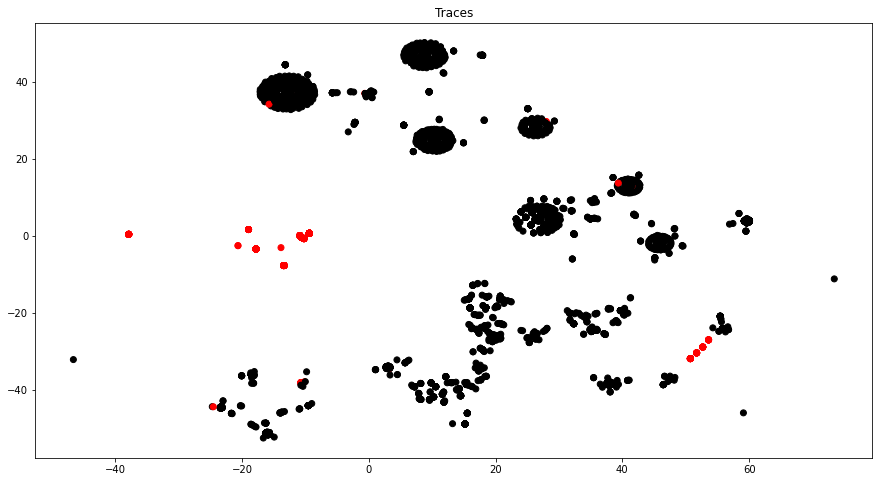

In [653]:
tsne = manifold.TSNE(n_components = 2,  random_state = 0, learning_rate = "auto", metric = 'precomputed')
trans_data = tsne.fit_transform(jac_sim).T

plt.figure(figsize=(15,8))
plt.scatter(trans_data[0], trans_data[1], c = y.ravel(), cmap =  ListedColormap(['black','red']))
plt.title('Traces')

In [655]:
from mpl_toolkits import mplot3d

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.


Text(0.5, 0.92, 'Traces')

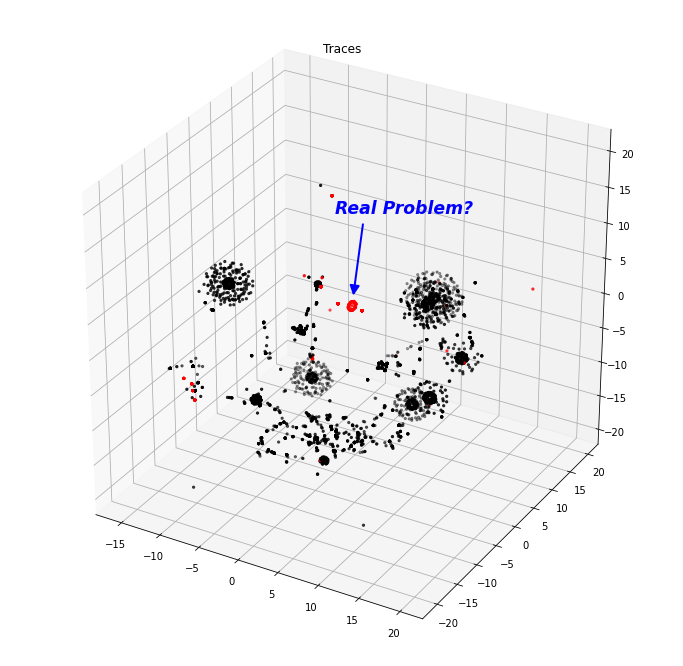

In [683]:
tsne = manifold.TSNE(n_components = 3,  random_state = 0, learning_rate = "auto", metric = 'precomputed')
trans_data = tsne.fit_transform(jac_sim).T

fig = plt.figure(figsize = (12,12))
ax = plt.axes(projection = '3d')

ax.scatter(trans_data[0], trans_data[1], trans_data[2], c = y.ravel(), 
           cmap =  ListedColormap(['black','red']), s = 5)
ax.text3D(0, 0, 15, "Real Problem?", color = 'blue', weight = 'bold', fontsize = 'xx-large', fontstyle = 'italic')

a = Arrow3D([2, 1.5], [3, 1.5], [13, 3], mutation_scale = 20,
            lw = 2, arrowstyle = "-|>", color = "blue")
ax.add_artist(a)

plt.title('Traces')

In [16]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

In [17]:
 class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)